In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.nice(19)

19

In [13]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
from astropy import constants as c
import matplotlib.animation as animation
%matplotlib inline

#styling
import seaborn as sns
sns.set_style(style='ticks', rc=None)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

matplotlib.rcParams.update({'font.size': 20})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=20

In [3]:
import batman

In [4]:
params = batman.TransitParams()
params.t0 = 0.                       #time of inferior conjunction
params.per = 1.                      #orbital period
params.rp = 0.1                      #planet radius (in units of stellar radii)
params.a = 15.                       #semi-major axis (in units of stellar radii)
params.inc = 87.                     #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

In [5]:
t = np.linspace(-0.013, 0.013, 100)
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)          #calculates light curve

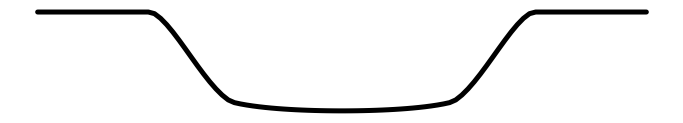

In [6]:
fig, ax = pl.subplots(figsize=(12, 2))

ax.plot(t, flux, lw=5, color='k')
ax.set_xlabel("Time from central transit")
ax.set_ylabel("Relative flux")
ax.axis('off')

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
fig.savefig('transit_white.png')

# spot crossing (gaussian)

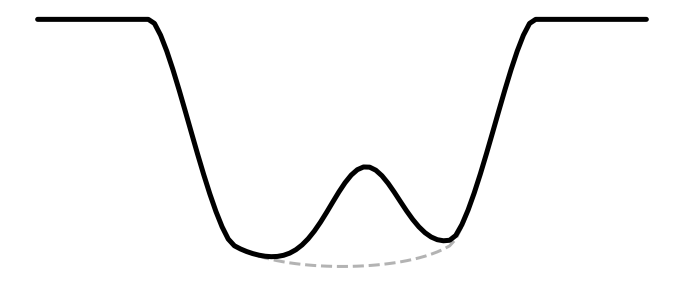

In [10]:
t = np.linspace(-0.013, 0.013, 100)
m = batman.TransitModel(params, t)
flux = m.light_curve(params)

# --- spot-crossing風ガウシアンbumpを定義 ---
A     = 4e-3        # 振幅（相対値；3000 ppm）
t0    = 0.0010      # バンプ中心時刻（days）
sigma = 1.5e-3  # 幅（days, 1σ）

bump = A * np.exp(-0.5 * ((t - t0) / sigma)**2)

# トランジット中だけ適用（任意）
in_transit = flux < 0.9995
flux_bumped = flux + bump * in_transit

# 1より大きく見せたくないならクリップ（任意）
flux_bumped = np.minimum(flux_bumped, 1.0)

# --- プロット ---
fig, ax = pl.subplots(figsize=(12, 5))
ax.plot(t, flux, lw=3, color='0.7', ls = 'dashed')
ax.plot(t, flux_bumped, lw=5, color='k', label='with spot-crossing bump')
ax.set_xlabel("Time from central transit [days]")
ax.set_ylabel("Relative flux")
ax.axis('off')
#ax.legend(loc='upper left', frameon=False)
fig.savefig('transit_with_bump.png', dpi=200)

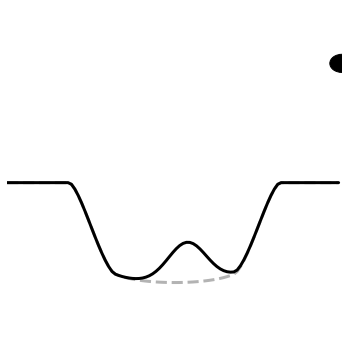

In [19]:
# --- 光度曲線データ ---
t = np.linspace(-0.013, 0.013, 100)
m = batman.TransitModel(params, t)
flux = m.light_curve(params)

# spot-crossing bump
A, t0, sigma = 4e-3, 0.0010, 1.5e-3
bump = A * np.exp(-0.5 * ((t - t0) / sigma)**2)
in_transit = flux < 0.9995
flux_bumped = np.minimum(flux + bump * in_transit, 1.0)

# --- Figure: 上段に丸, 下段にライトカーブ ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6), gridspec_kw={'height_ratios':[1,1.5]})
fig.subplots_adjust(hspace=0.3)

# 上のパネル（惑星の黒丸だけ）
ax1.set_xlim(-1.1, 1.1)
ax1.set_ylim(0, 1)
ax1.axis('off')
planet = plt.Circle((-1.1, 0.5), 0.08, color='k')
ax1.add_patch(planet)

# 下のパネル（ライトカーブ）
ax2.set_xlim(t.min(), t.max())
ax2.set_ylim(0.985, 1.002)
ax2.set_xlabel("Time from central transit [days]")
ax2.set_ylabel("Relative flux")
ax2.axis('off')

line1, = ax2.plot([], [], lw=3, color='0.7', ls='dashed')
line2, = ax2.plot([], [], lw=3, color='k')

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    planet.center = (-1.1, 0.5)
    return line1, line2, planet

def update(i):
    # ライトカーブを更新
    line1.set_data(t[:i], flux[:i])
    line2.set_data(t[:i], flux_bumped[:i])
    # 黒丸を左→右に移動
    x = np.linspace(-1.1, 1.1, len(t))[i]
    planet.center = (x, 0.5)
    return line1, line2, planet

ani = animation.FuncAnimation(fig, update, frames=len(t),
                              init_func=init, blit=True, interval=50)

for i in range(len(t)):
    update(i)
    fig.savefig(f"gif_frames/frames_{i:03d}.png", facecolor='white')

Saved as transit_with_planet.gif


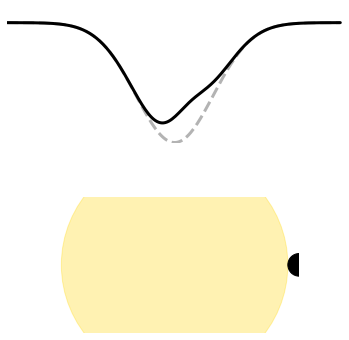

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

in_transit = flux < 0.9995
flux_bumped = flux + bump * in_transit
flux_bumped = np.minimum(flux_bumped, 1.0)

# --- Figure & Axes ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6))
fig.subplots_adjust(hspace=0.4)

# ライトカーブ領域
ax1.set_xlim(t.min(), t.max())
ax1.set_ylim(0.985, 1.002)
ax1.set_xlabel("Time from central transit [days]")
ax1.set_ylabel("Relative flux")
ax1.axis('off')
line1, = ax1.plot([], [], lw=3, color='0.7', ls='dashed')
line2, = ax1.plot([], [], lw=3, color='k')

# 惑星の動きを示す領域
ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-0.1, 1.1)
ax2.set_aspect("equal")
ax2.axis('off')

# 恒星を背景に（黄色円）
star = plt.Circle((0,0.5), 1.0, color='gold', alpha=0.3)
ax2.add_patch(star)

# 惑星の円（黒丸）
planet = plt.Circle((-1.1,0.5), 0.1, color='k')
ax2.add_patch(planet)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    planet.center = (-1.1, 0.5)
    return line1, line2, planet

def update(i):
    # ライトカーブ描画
    line1.set_data(t[:i], flux[:i])
    line2.set_data(t[:i], flux_bumped[:i])
    
    # 惑星を左→右へ移動
    x = np.linspace(-1.1, 1.1, len(t))[i]
    planet.center = (x, 0.5)
    return line1, line2, planet

ani = animation.FuncAnimation(fig, update, frames=len(t),
                              init_func=init, blit=True, interval=50)

# --- 透過GIF保存 ---
ani.save("transit_with_planet.gif", writer="pillow", dpi=100, savefig_kwargs={'transparent': True})

print("Saved as transit_with_planet.gif")

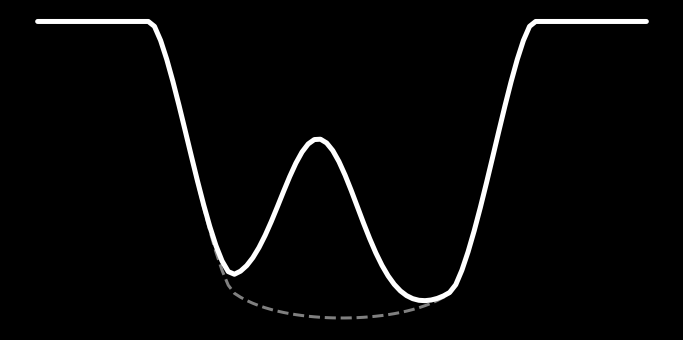

In [17]:
fig, ax = pl.subplots(figsize=(12, 6))

# 背景を黒に
fig.patch.set_facecolor("black")  # 図全体の背景
ax.set_facecolor("black")         # プロット部分の背景

# 軸の色やラベルも白にする
ax.plot(t, flux, lw=3, color='0.5', ls='dashed')
ax.plot(t, flux_bumped, lw=5, color='w', label='with spot-crossing bump')
ax.set_xlabel("Time from central transit [days]", color="w")
ax.set_ylabel("Relative flux", color="w")

# 軸の目盛も白にする
ax.tick_params(colors="w")

# 枠線も白に
for spine in ax.spines.values():
    spine.set_color("w")

ax.axis('off')  # 軸を消すなら

fig.savefig('transit_with_bump_blackbg.png', dpi=200, transparent=True)